# Test supervised pyrat 

1. Generate data in terminal PyRat: 

python3 pyrat.py -p 40 -md 0 -d 0 --nonsymmetric --rat AIs/manh.py --python AIs/manh.py --tests 1000 --nodrawing --synchronous --save

In [1]:
# The tqdm package is useful to visualize progress with long computations. 
# Install it using pip 
import tqdm

import numpy as np
import ast
import os

2. Generate Dataset 


In [3]:
### The goal of this function is to create a canvas, which will be the vector used to train the classifier. 
### As we want to predict a next move, we will create a canvas that is centered on the player, so that we can easily with the translation invariance. 


def convert_input_2(player, maze, opponent, mazeHeight, mazeWidth, piecesOfCheese):
	# We will consider twice the size of the maze to simplify the creation of the canvas 
	# The canvas is initialized as a numpy tensor with 3 modes (meaning it is indexed using three integers), the third one corresponding to "layers" of the canvas. 
	# Here, we just use one layer, but you can defined other ones to put more information on the play (e.g. the location of the opponent could be put in a second layer)

    im_size = (2*mazeHeight-1,2*mazeWidth-1,1)

    # We initialize a canvas with only zeros
    canvas = np.zeros(im_size)


    (x,y) = player

    # fill in the first layer of the canvas with the value 1 at the location of the cheeses, relative to the position of the player (i.e. the canvas is centered on the player location)
    center_x, center_y = mazeWidth-1, mazeHeight-1
    for (x_cheese,y_cheese) in piecesOfCheese:
        x_ = y_cheese+center_y-y
        y_ = x_cheese+center_x-x
        canvas[x_,y_,0] = 1      
       
    return canvas


In [4]:
import scipy
import scipy.sparse

PHRASES = {
    "# Random seed\n": "seed",
    "# MazeMap\n": "maze",
    "# Pieces of cheese\n": "pieces"    ,
    "# Rat initial location\n": "rat"    ,
    "# Python initial location\n": "python"   , 
    "rat_location then python_location then pieces_of_cheese then rat_decision then python_decision\n": "play"
}

MOVE_DOWN = 'D'
MOVE_LEFT = 'L'
MOVE_RIGHT = 'R'
MOVE_UP = 'U'

translate_action = {
    MOVE_LEFT:0,
    MOVE_RIGHT:1,
    MOVE_UP:2,
    MOVE_DOWN:3
}# This data structures defines the encoding of the four possible movements

def process_file_2(filename):
    f = open(filename,"r")    
    info = f.readline()
    params = dict(play=list())
    while info is not None:
        if info.startswith("{"):
            params["end"] = ast.literal_eval(info)
            break
        if "turn " in info:
            info = info[info.find('rat_location'):]
        if info in PHRASES.keys():
            param = PHRASES[info]
            if param == "play":
                rat = ast.literal_eval(f.readline())
                python = ast.literal_eval(f.readline())
                pieces = ast.literal_eval(f.readline())
                rat_decision = f.readline().replace("\n","")
                python_decision = f.readline().replace("\n","")
                play_dict = dict(
                    rat=rat,python=python,piecesOfCheese=pieces,
                    rat_decision=rat_decision,python_decision=python_decision)
                params[param].append(play_dict)
            else:
                params[param] = ast.literal_eval(f.readline())
        else:
            print("did not understand:", info)
            break
        info = f.readline()
    return params

def dict_to_x_y(end,rat, python, maze, piecesOfCheese,rat_decision,python_decision,
                mazeWidth=21, mazeHeight=15):
    # We only use the winner
    if end["win_python"] == 1: 
        player = python
        opponent = rat        
        decision = python_decision
    elif end["win_rat"] == 1:
        player = rat
        opponent = python        
        decision = rat_decision
    else:
        return False
    if decision == "None" or decision == "": #No play
        return False
    x_1 = convert_input_2(player, maze, opponent, mazeHeight, mazeWidth, piecesOfCheese)
    y = np.zeros((1,4),dtype=np.int8)
    y[0][translate_action[decision]] = 1
    return x_1,y

In [2]:
# center in player

In [5]:
games = list()
directory = "/home/brain/IA/PyRat/saves/"
for root, dirs, files in os.walk(directory):
    for filename in tqdm.tqdm(files):
        if filename.startswith("."):
            continue
        game_params = process_file_2(directory+filename)
        games.append(game_params)

x_1_train = list()
y_train = list()
wins_python = 0
wins_rat = 0
for game in tqdm.tqdm(games):
    if game["end"]["win_python"] == 1: 
        wins_python += 1
    elif game["end"]["win_rat"] == 1:
        wins_rat += 1
    else:
        continue
    plays = game["play"]
    for play in plays:
        x_y = dict_to_x_y(**play,maze=game_params["maze"],end=game["end"])
        if x_y:
            x1, y = x_y
            y_train.append(scipy.sparse.csr_matrix(y.reshape(1,-1)))
            x_1_train.append(scipy.sparse.csr_matrix(x1.reshape(1,-1)))
print("Greedy/Draw/Greedy, {}/{}/{}".format(wins_rat,1000 - wins_python - wins_rat, wins_python)) 

100%|██████████| 1000/1000 [00:17<00:00, 55.82it/s]

Greedy/Draw/Greedy, 435/121/444


In [6]:
# dataset moves
np.savez_compressed("dataset_challenge_moves_supervised.npz",x=x_1_train,y=y_train)
del x_1_train
del y_train

# LOAD DATASET

In [5]:
from sklearn.model_selection import train_test_split

### This cell reloads the pyrat_dataset that was stored as a pkl file by the generate dataset script. 

mazeWidth = 21
mazeHeight = 15

import pickle, scipy

x = np.load("dataset_challenge_moves_supervised.npz")['x']
y = np.load("dataset_challenge_moves_supervised.npz")['y']

x = scipy.sparse.vstack(x)

## The dataset was stored using scipy sparse arrays, because the matrices contain mostly zeros. In case you wish to use 
## supervised learning techniques that don't accept sparse matrices, you have to convert x into a dense array and reshape it accordingly
#x = x.todense()
#x = np.array(x).reshape(-1,(2*mazeHeight-1)*(2*mazeWidth-1))

y = scipy.sparse.vstack(y).todense()
y = np.argmax(np.array(y),1)

In [6]:
print(x.shape, y.shape)

(59461, 1189) (59461,)


## -  Neural Network model

In [7]:
from sklearn.neural_network import MLPClassifier

### Now you have to train a classifier using supervised learning and evaluate it's performance. 
#Split dataset

x_train, x_test, y_train, y_test = train_test_split(x[:,:], y[:], test_size=0.20, random_state=1)

clf = MLPClassifier(verbose = 1)
clf.fit(x_train,y_train)
print(clf.score(x_train,y_train),clf.score(x_test,y_test))

Iteration 1, loss = 0.71093283
Iteration 2, loss = 0.33446897
Iteration 3, loss = 0.28716221
Iteration 4, loss = 0.25256984
Iteration 5, loss = 0.21776830
Iteration 6, loss = 0.18465736
Iteration 7, loss = 0.15570156
Iteration 8, loss = 0.13076041
Iteration 9, loss = 0.11006197
Iteration 10, loss = 0.09278392
Iteration 11, loss = 0.07880549
Iteration 12, loss = 0.06677090
Iteration 13, loss = 0.05696180
Iteration 14, loss = 0.04877961
Iteration 15, loss = 0.04155483
Iteration 16, loss = 0.03581066
Iteration 17, loss = 0.03099764
Iteration 18, loss = 0.02681082
Iteration 19, loss = 0.02323794
Iteration 20, loss = 0.02030206
Iteration 21, loss = 0.01762615
Iteration 22, loss = 0.01582351
Iteration 23, loss = 0.01391256
Iteration 24, loss = 0.01225752
Iteration 25, loss = 0.01079093
Iteration 26, loss = 0.00948683
Iteration 27, loss = 0.00837580
Iteration 28, loss = 0.00734351
Iteration 29, loss = 0.00662508
Iteration 30, loss = 0.00632115
Iteration 31, loss = 0.00603689
Iteration 32, los

### report model 

Train Set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12765
          1       1.00      1.00      1.00     12414
          2       1.00      1.00      1.00     11142
          3       1.00      1.00      1.00     11247

avg / total       1.00      1.00      1.00     47568

Test Set:
             precision    recall  f1-score   support

          0       0.91      0.92      0.91      3175
          1       0.90      0.90      0.90      3102
          2       0.94      0.93      0.93      2840
          3       0.93      0.93      0.93      2776

avg / total       0.92      0.92      0.92     11893



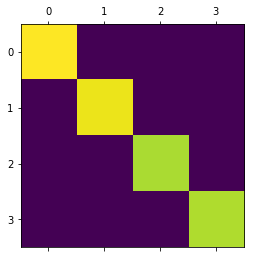

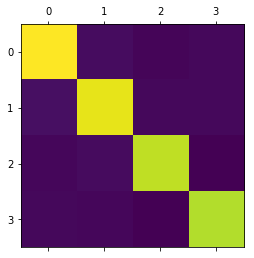

In [9]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred_train = clf.predict(x_train)
report = classification_report(y_true=y_train,y_pred=y_pred_train)

print("Train Set:")
print(report)


y_pred_test = clf.predict(x_test)
report = classification_report(y_true=y_test,y_pred=y_pred_test)

print("Test Set:")
print(report)

matrix = confusion_matrix(y_true=y_train,y_pred=y_pred_train)
plt.matshow(matrix)
matrix = confusion_matrix(y_true=y_test,y_pred=y_pred_test)
plt.matshow(matrix)

### save model 

In [6]:
### Let's assume you have named your classifier clf . You can save the trained object using the joblib.dump method, as follows: 

import pickle
from sklearn.externals import joblib

joblib.dump(clf, 'mlp_classifier_moves.pkl') 

# Test in pyrat
## Now you can use the supervised.py file as an AI directly in Pyrat. 


['mlp_classifier_moves.pkl']

All you have to do is copy the mlp_classifier_moves.pkl to the **pyrat folder** and supervised.py to the **pyrat AIs subfolder** to test how the trained classifier performs while playing !

In [ ]:
from sklearn.manifold import TSNE
unsup = TSNE(random_state = 0)
examples = unsup.fit_transform(x.todense())
plt.scatter(examples[:,0],examples[:,1],c=y)
plt.colorbar()

In [3]:
import numpy as np
def generate_canvas_opponnent(mux,muy,sigma = 5,mazeWidth=21,mazeHeight=15): 
    x, y = np.meshgrid(np.linspace(-mazeWidth,mazeWidth,2*mazeWidth-1), np.linspace(-mazeHeight,mazeHeight,2*mazeHeight-1))
    return np.exp(-( ((x-mux)**2+(y-muy)**2) / ( 2.0 * sigma**2 ) ) )
print(generate_canvas_opponnent(0,0).shape)
from matplotlib import pyplot as plt
plt.imshow(generate_canvas_opponnent(0,0))
plt.colorbar()
plt.show()

(29, 41)


<Figure size 640x480 with 2 Axes>

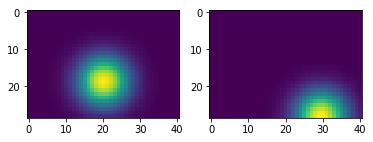

In [6]:
mazeWidth = 21
mazeHeight = 15
im_size = (2*mazeHeight-1,2*mazeWidth-1,2)
canvas = np.zeros(im_size)
canvas[:,:,0] = generate_canvas_opponnent(0,5)
canvas[:,:,1] = generate_canvas_opponnent(10,15)
plt.subplot(1,2,1)
plt.imshow(canvas[:,:,0])
plt.subplot(1,2,2)
plt.imshow(canvas[:,:,1])
plt.show()



In [170]:
import scipy
import scipy.sparse
x_1_train = list()
x_1_train.append(scipy.sparse.csr_matrix(canvas.reshape(1,-1)))
print(x_1_train[0].shape)

(1, 2378)


In [120]:
x = scipy.sparse.vstack(x_1_train).todense()
print(x.shape)

(1, 2378)


In [143]:
a = np.array([[1,2,3], [4,5,6]])
print(a)
print(a.reshape(-1))


[[1 2 3]
 [4 5 6]]
[1 2 3 4 5 6]


# load original images

(1, 2378)


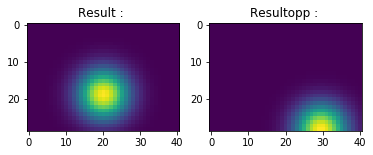

In [10]:
x = canvas[:,:,0].reshape(1,-1)
x2 = canvas[:,:,1].reshape(1,-1)
X = np.concatenate((x,x2),axis=1)
print(X.shape)
cheese = X[:,0:1189].reshape(2*mazeHeight-1,2*mazeWidth-1)
opp = X[:,1189:].reshape(2*mazeHeight-1,2*mazeWidth-1)

plt.subplot(1,2,1)
plt.imshow(cheese)
plt.title('Result : ')


plt.subplot(1,2,2)
plt.imshow(opp)
plt.title('Resultopp : ')
plt.show()https://www.google.com/search?q=gross+titre&oq=gross+titre&aqs=chrome..69i57j0l5.3351j1j4&sourceid=chrome&ie=UTF-8

In [51]:
Y = np.asarray([X,X])
print(Y.shape)
W= Y.reshape(2,2*mazeHeight-1,2*mazeWidth-1,-1)

(2, 1, 2378)


In [50]:
print(W.shape)

(2, 29, 41, 2)


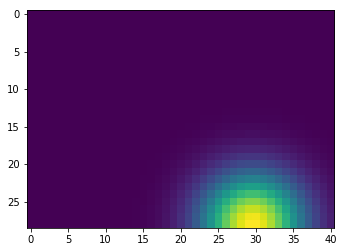

In [43]:
plt.imshow(W[1,:,:])